In [1]:
# # Update sklearn to prevent version mismatches
# !pip install sklearn --upgrade

# # install joblib. This will be used to save your model. 
# # Restart your kernel after installing 
# !pip install joblib

<H3> Context </H3>
The Kepler Space Observatory is a NASA-build satellite that was launched in 2009. The telescope is dedicated to searching for exoplanets in star systems besides our own, with the ultimate goal of possibly finding other habitable planets besides our own. The original mission ended in 2013 due to mechanical failures, but the telescope has nevertheless been functional since 2014 on a "K2" extended mission.

Kepler had verified 1284 new exoplanets as of May 2016. As of October 2017 there are over 3000 confirmed exoplanets total (using all detection methods, including ground-based ones). The telescope is still active and continues to collect new data on its extended mission.

<h3> Content </h3>
This dataset is a cumulative record of all observed Kepler "objects of interest" (KOI) — basically, all of the approximately 10,000 exoplanet candidates Kepler has taken observations on.

This dataset has an extensive data dictionary, which can be accessed here.

https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

In [2]:
import pandas as pd
import numpy as np
import joblib

# Read the CSV and Perform Basic Data Cleaning

In [3]:
df = pd.read_csv("exoplanet_data.csv")
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
# Drop all koi_disposition == "candidate"
df = df.loc[df.koi_disposition != "CANDIDATE"]

df.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,FALSE POSITIVE,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,...,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
2,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
3,CONFIRMED,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,...,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
4,CONFIRMED,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,...,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


# Select your features (columns)

In [4]:
# Set features. This will also be used as your x values.
setFeatures = [
'koi_fpflag_nt',
'koi_fpflag_ss',
'koi_fpflag_co',
'koi_fpflag_ec',
'koi_period',
'koi_time0bk',
'koi_impact',
'koi_duration',
'koi_depth',
'koi_prad',
'koi_teq',
'koi_insol',
'koi_model_snr',
'koi_tce_plnt_num',
'koi_steff',
'koi_slogg',
'koi_srad',
'ra',
'dec',
'koi_kepmag',
]

selected_features = df[setFeatures].copy()
selected_features.tail()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
6983,0,1,0,0,21.513523,132.335600,2.441,77.9830,1583.8,534.47,1006,242.54,171.5,1,5088,3.508,3.318,287.46786,37.966640,10.630
6986,0,0,0,1,8.589871,132.016100,0.765,4.8060,87.7,1.11,929,176.40,8.4,1,5638,4.296,1.088,298.74921,46.973351,14.478
6987,0,1,1,0,0.527699,131.705093,1.252,3.2221,1579.2,29.35,2088,4500.53,453.3,1,5638,4.529,0.903,297.18875,47.093819,14.082
6989,0,0,1,0,0.681402,132.181750,0.147,0.8650,103.6,1.07,2218,5713.41,12.3,1,6173,4.447,1.041,294.16489,47.176281,15.385
6990,0,0,1,1,4.856035,135.993300,0.134,3.0780,76.7,1.05,1266,607.42,8.2,1,6469,4.385,1.193,297.00977,47.121021,14.826


## Create a Train Test Split
Use `koi_disposition` for the y values

In [5]:
# getting y ready
df['koi_disposition'].where(df['koi_disposition'] == "CONFIRMED", 0)
df['koi_disposition_one_hot'] = np.where(df['koi_disposition'] == 'CONFIRMED', 1, 0)

y = df['koi_disposition_one_hot'] .copy()
y.head()

0    1
1    0
2    0
3    1
4    1
Name: koi_disposition_one_hot, dtype: int32

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(selected_features, y, random_state=555)

display(X_train.head(), y.head())

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
2631,0,0,1,1,1.160153,121.704645,0.748,1.3433,170.2,1.40,1751,2229.29,48.4,1,5842,4.433,0.985,298.66101,41.137890,12.450
5598,0,0,1,1,2.196429,133.494500,0.004,4.9330,99.5,0.79,1193,477.24,11.8,1,5376,4.576,0.806,291.83594,42.564838,15.811
4427,0,0,1,0,4.750257,134.638890,0.727,1.9278,395.1,12.35,2090,4504.96,42.7,1,5161,3.192,5.753,294.09631,39.647079,11.540
891,0,0,0,0,3.517495,135.546724,0.742,1.5639,532.8,1.42,704,58.08,52.6,1,4132,4.699,0.564,291.15295,40.887489,14.699
2766,0,0,1,0,1.106012,131.835990,0.532,2.5770,52.9,0.77,1903,3093.39,15.5,1,6241,4.450,1.031,289.17761,41.695171,14.363


0    1
1    0
2    0
3    1
4    1
Name: koi_disposition_one_hot, dtype: int32

## Pre-processing

Scale the data using the MinMaxScaler and perform some feature selection

In [7]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler
X_scaler =  MinMaxScaler().fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Train the Logistic Model



In [8]:
# model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

# fit
classifier.fit(X_train, y_train)

# Predict
print(f"Training Data Score: {classifier.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test_scaled, y_test)}")

Training Data Score: 0.563097033685269
Testing Data Score: 0.5701357466063348


C:\Users\AustinWen\.conda\envs\pyadv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Train the KNN Model

k: 1, Train/Test Score: 1.000/0.983
k: 3, Train/Test Score: 0.991/0.992
k: 5, Train/Test Score: 0.990/0.992
k: 7, Train/Test Score: 0.990/0.992
k: 9, Train/Test Score: 0.990/0.992
k: 11, Train/Test Score: 0.990/0.992
k: 13, Train/Test Score: 0.990/0.992
k: 15, Train/Test Score: 0.990/0.992
k: 17, Train/Test Score: 0.990/0.992
k: 19, Train/Test Score: 0.990/0.992


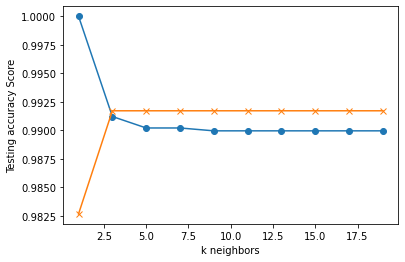

In [9]:
# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties

from sklearn.neighbors import KNeighborsClassifier
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    

import matplotlib.pyplot as plt
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [10]:
# model
knn = KNeighborsClassifier(n_neighbors=3)
# fit
knn.fit(X_train_scaled, y_train)
# predict
print(f"Training Data Score: {knn.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {knn.score(X_test_scaled, y_test)}")

Training Data Score: 0.9912016088486677
Testing Data Score: 0.9917043740573153


In [11]:
# Save
filename = 'koi_ML_knn.h5'
joblib.dump(knn, filename)

['koi_ML_knn.h5']

## Train the SVM

In [12]:
from sklearn.svm import SVC 
# model
svm = SVC(kernel='linear')
# fit
svm.fit(X_train_scaled, y_train)
# predict
print(f"Training Data Score: {svm.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {svm.score(X_test_scaled, y_test)}")

Training Data Score: 0.9899446958270488
Testing Data Score: 0.9917043740573153


In [13]:
# Save
filename = 'koi_ML_svm.h5'
joblib.dump(svm, filename)

['koi_ML_svm.h5']

# Hyperparameter Tuning

Use `GridSearchCV` to tune the model's parameters

In [14]:
# Create the GridSearchCV model
from sklearn.model_selection import GridSearchCV
param_grid = {'C'  : [1, 5, 10],
              'kernel': ['linear', 'rbf'],
              'gamma': [0.0001, 0.001, 0.01]}
grid = GridSearchCV(svm, param_grid, verbose=3)

In [15]:
# Train the model with GridSearch
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] C=1, gamma=0.0001, kernel=linear ................................
[CV] .... C=1, gamma=0.0001, kernel=linear, score=0.989, total=   0.1s
[CV] C=1, gamma=0.0001, kernel=linear ................................
[CV] .... C=1, gamma=0.0001, kernel=linear, score=0.990, total=   0.1s
[CV] C=1, gamma=0.0001, kernel=linear ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .... C=1, gamma=0.0001, kernel=linear, score=0.995, total=   0.1s
[CV] C=1, gamma=0.0001, kernel=linear ................................
[CV] .... C=1, gamma=0.0001, kernel=linear, score=0.991, total=   0.1s
[CV] C=1, gamma=0.0001, kernel=linear ................................
[CV] .... C=1, gamma=0.0001, kernel=linear, score=0.985, total=   0.0s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.658, total=   0.4s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.658, total=   0.5s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.658, total=   0.4s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ....... C=1, gamma=0.0001, kernel=rbf, score=0.659, total=   0.4s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   19.9s finished


GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [1, 5, 10], 'gamma': [0.0001, 0.001, 0.01],
                         'kernel': ['linear', 'rbf']},
             verbose=3)

In [16]:
print(grid.best_params_)
print(grid.best_score_)

{'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
0.9899437438766159


# Save the Model

In [17]:
# save your model by updating "your_name" with your name
# and "your_model" with your model variable
# be sure to turn this in to BCS
# if joblib fails to import, try running the command to install in terminal/git-bash
filename = 'koi_ML_grid.h5'
joblib.dump(grid, filename)

['koi_ML_grid.h5']